# Continuous State Markov Chains


<a id='index-1'></a>

## Contents

- [Continuous State Markov Chains](#Continuous-State-Markov-Chains)  
  - [Overview](#Overview)  
  - [The Density Case](#The-Density-Case)  
  - [Beyond Densities](#Beyond-Densities)  
  - [Stability](#Stability)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  
  - [Appendix](#Appendix)  

## Overview

In a [previous lecture](https://lectures.quantecon.org/jl/finite_markov.html) we learned about finite Markov chains, a relatively elementary class of stochastic dynamic models

The present lecture extends this analysis to continuous (i.e., uncountable) state Markov chains

Most stochastic dynamic models studied by economists either fit directly into this class or can be represented as continuous state Markov chains after minor modifications

In this lecture, our focus will be on continuous Markov models that

- evolve in discrete time  
- are often nonlinear  


The fact that we accommodate nonlinear models here is significant, because
linear stochastic models have their own highly developed tool set, as we’ll
see [later on](https://lectures.quantecon.org/jl/arma.html)

The question that interests us most is: Given a particular stochastic dynamic
model, how will the state of the system evolve over time?

In particular,

- What happens to the distribution of the state variables?  
- Is there anything we can say about the “average behavior” of these variables?  
- Is there a notion of “steady state” or “long run equilibrium” that’s applicable to the model?  
  
  - If so, how can we compute it?  
  


Answering these questions will lead us to revisit many of the topics that occupied us in the finite state case,
such as simulation, distribution dynamics, stability, ergodicity, etc.

>**Note**
>
>For some people, the term “Markov chain” always refers to a process with a
finite or discrete state space.  We follow the mainstream
mathematical literature (e.g., [[MT09]](https://lectures.quantecon.org/jl/zreferences.html#meyntweedie2009)) in using the term to refer to any discrete **time**
Markov process

### Setup

In [1]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLecturePackages", tag = "v0.9.5");

In [2]:
using LinearAlgebra, Statistics, Compat
using KernelDensity, Distributions, Plots, QuantEcon, Random


<a id='statd-density-case'></a>

## The Density Case

You are probably aware that some distributions can be represented by densities
and some cannot

(For example, distributions on the real numbers $ \mathbb R $ that put positive probability
on individual points have no density representation)

We are going to start our analysis by looking at Markov chains where the one step transition probabilities have density representations

The benefit is that the density case offers a very direct parallel to the finite case in terms of notation and intuition

Once we’ve built some intuition we’ll cover the general case

### Definitions and Basic Properties

In our [lecture on finite Markov chains](https://lectures.quantecon.org/jl/finite_markov.html), we studied discrete time Markov chains that evolve on a finite state space $ S $

In this setting, the dynamics of the model are described by a stochastic matrix — a nonnegative square matrix $ P = P[i, j] $ such that each row $ P[i, \cdot] $ sums to one

The interpretation of $ P $ is that $ P[i, j] $ represents the
probability of transitioning from state $ i $ to state $ j $ in one
unit of time

In symbols,

$$
\mathbb P \{ X_{t+1} = j \,|\, X_t = i \} = P[i, j]
$$

Equivalently,

- $ P $ can be thought of as a family of distributions $ P[i, \cdot] $, one for each $ i \in S $  
- $ P[i, \cdot] $ is the distribution of $ X_{t+1} $ given $ X_t = i $  


(As you probably recall, when using Julia arrays, $ P[i, \cdot] $ is expressed as `P[i,:]`)

In this section, we’ll allow $ S $ to be a subset of $ \mathbb R $, such as

- $ \mathbb R $ itself  
- the positive reals $ (0, \infty) $  
- a bounded interval $ (a, b) $  


The family of discrete distributions $ P[i, \cdot] $ will be replaced by a family of densities $ p(x, \cdot) $, one for each $ x \in S $

Analogous to the finite state case, $ p(x, \cdot) $ is to be understood as the distribution (density) of $ X_{t+1} $ given $ X_t = x $

More formally, a *stochastic kernel on* $ S $ is a function $ p \colon S \times S \to \mathbb R $ with the property that

1. $ p(x, y) \geq 0 $ for all $ x, y \in S $  
1. $ \int p(x, y) dy = 1 $ for all $ x \in S $  


(Integrals are over the whole space unless otherwise specified)

For example, let $ S = \mathbb R $ and consider the particular stochastic
kernel $ p_w $ defined by


<a id='equation-statd-rwsk'></a>
$$
p_w(x, y) := \frac{1}{\sqrt{2 \pi}} \exp \left\{ - \frac{(y - x)^2}{2} \right\} \tag{1}
$$

What kind of model does $ p_w $ represent?

The answer is, the (normally distributed) random walk


<a id='equation-statd-rw'></a>
$$
X_{t+1} = X_t + \xi_{t+1}
\quad \text{where} \quad
\{ \xi_t \} \stackrel {\textrm{ IID }} {\sim} N(0, 1) \tag{2}
$$

To see this, let’s find the stochastic kernel $ p $ corresponding to [(2)](#equation-statd-rw)

Recall that $ p(x, \cdot) $ represents the distribution of $ X_{t+1} $ given $ X_t = x $

Letting $ X_t = x $ in [(2)](#equation-statd-rw) and considering the distribution of $ X_{t+1} $, we see that $ p(x, \cdot) = N(x, 1) $

In other words, $ p $ is exactly $ p_w $, as defined in [(1)](#equation-statd-rwsk)

### Connection to Stochastic Difference Equations

In the previous section, we made the connection between stochastic difference
equation [(2)](#equation-statd-rw) and stochastic kernel [(1)](#equation-statd-rwsk)

In economics and time series analysis we meet stochastic difference equations of all different shapes and sizes

It will be useful for us if we have some systematic methods for converting stochastic difference equations into stochastic kernels

To this end, consider the generic (scalar) stochastic difference equation given by


<a id='equation-statd-srs'></a>
$$
X_{t+1} = \mu(X_t) + \sigma(X_t) \, \xi_{t+1} \tag{3}
$$

Here we assume that

- $ \{ \xi_t \} \stackrel {\textrm{ IID }} {\sim} \phi $, where $ \phi $ is a given density on $ \mathbb R $  
- $ \mu $ and $ \sigma $ are given functions on $ S $, with $ \sigma(x) > 0 $ for all $ x $  


**Example 1:** The random walk [(2)](#equation-statd-rw) is a special case of [(3)](#equation-statd-srs), with $ \mu(x) = x $ and $ \sigma(x) = 1 $

**Example 2:** Consider the [ARCH model](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity)

$$
X_{t+1} = \alpha X_t + \sigma_t \,  \xi_{t+1},
\qquad \sigma^2_t = \beta + \gamma X_t^2,
\qquad \beta, \gamma > 0
$$

Alternatively, we can write the model as


<a id='equation-statd-arch'></a>
$$
X_{t+1} = \alpha X_t + (\beta + \gamma X_t^2)^{1/2} \xi_{t+1} \tag{4}
$$

This is a special case of [(3)](#equation-statd-srs) with $ \mu(x) = \alpha x $ and $ \sigma(x) = (\beta + \gamma x^2)^{1/2} $


<a id='solow-swan'></a>
**Example 3:** With stochastic production and a constant savings rate, the one-sector neoclassical growth model leads to a law of motion for capital per worker such as


<a id='equation-statd-ss'></a>
$$
k_{t+1} = s  A_{t+1} f(k_t) + (1 - \delta) k_t \tag{5}
$$

Here

- $ s $ is the rate of savings  
- $ A_{t+1} $ is a production shock  
  
  - The $ t+1 $ subscript indicates that $ A_{t+1} $ is not visible at time $ t $  
  
- $ \delta $ is a depreciation rate  
- $ f \colon \mathbb R_+ \to \mathbb R_+ $ is a production function satisfying $ f(k) > 0 $ whenever $ k > 0 $  


(The fixed savings rate can be rationalized as the optimal policy for a particular set of technologies and preferences (see [[LS18]](https://lectures.quantecon.org/jl/zreferences.html#ljungqvist2012), section
3.1.2), although we omit the details here)

Equation [(5)](#equation-statd-ss) is a special case of [(3)](#equation-statd-srs) with $ \mu(x) = (1 - \delta)x $ and $ \sigma(x) = s f(x) $

Now let’s obtain the stochastic kernel corresponding to the generic model [(3)](#equation-statd-srs)

To find it, note first that if $ U $ is a random variable with
density $ f_U $, and $ V = a + b U $ for some constants $ a,b $
with $ b > 0 $, then the density of $ V $ is given by


<a id='equation-statd-dv'></a>
$$
f_V(v)
= \frac{1}{b}
f_U \left( \frac{v - a}{b} \right) \tag{6}
$$

(The proof is [below](#statd-appendix).  For a multidimensional version
see [EDTC](http://johnstachurski.net/edtc.html), theorem 8.1.3)

Taking [(6)](#equation-statd-dv) as given for the moment, we can
obtain the stochastic kernel $ p $ for [(3)](#equation-statd-srs) by recalling that
$ p(x, \cdot) $ is the conditional density of $ X_{t+1} $ given
$ X_t = x $

In the present case, this is equivalent to stating that $ p(x, \cdot) $ is the density of $ Y := \mu(x) + \sigma(x) \, \xi_{t+1} $ when $ \xi_{t+1} \sim \phi $

Hence, by [(6)](#equation-statd-dv),


<a id='equation-statd-srssk'></a>
$$
p(x, y)
= \frac{1}{\sigma(x)}
\phi \left( \frac{y - \mu(x)}{\sigma(x)} \right) \tag{7}
$$

For example, the growth model in [(5)](#equation-statd-ss) has stochastic kernel


<a id='equation-statd-sssk'></a>
$$
p(x, y)
= \frac{1}{sf(x)}
\phi \left( \frac{y - (1 - \delta) x}{s f(x)} \right) \tag{8}
$$

where $ \phi $ is the density of $ A_{t+1} $

(Regarding the state space $ S $ for this model, a natural choice is $ (0, \infty) $ — in which case
$ \sigma(x) = s f(x) $ is strictly positive for all $ s $ as required)

### Distribution Dynamics

In [this section](https://lectures.quantecon.org/jl/finite_markov.html#mc-md) of our lecture on **finite** Markov chains, we
asked the following question: If

1. $ \{X_t\} $ is a Markov chain with stochastic matrix $ P $  
1. the distribution of $ X_t $ is known to be $ \psi_t $  


then what is the distribution of $ X_{t+1} $?

Letting $ \psi_{t+1} $ denote the distribution of $ X_{t+1} $, the
answer [we gave](https://lectures.quantecon.org/jl/finite_markov.html#mc-fdd) was that

$$
\psi_{t+1}[j] = \sum_{i \in S} P[i,j] \psi_t[i]
$$

This intuitive equality states that the probability of being at $ j $
tomorrow is the probability of visiting $ i $ today and then going on to
$ j $, summed over all possible $ i $

In the density case, we just replace the sum with an integral and probability
mass functions with densities, yielding


<a id='equation-statd-fdd'></a>
$$
\psi_{t+1}(y) = \int p(x,y) \psi_t(x) \, dx,
\qquad \forall y \in S \tag{9}
$$

It is convenient to think of this updating process in terms of an operator

(An operator is just a function, but the term is usually reserved for a function that sends functions into functions)

Let $ \mathscr D $ be the set of all densities on $ S $, and let
$ P $ be the operator from $ \mathscr D $ to itself that takes density
$ \psi $ and sends it into new density $ \psi P $, where the latter is
defined by


<a id='equation-def-dmo'></a>
$$
(\psi P)(y) = \int p(x,y) \psi(x) dx \tag{10}
$$

This operator is usually called the *Markov operator* corresponding to $ p $

>**Note**
>
>Unlike most operators, we write $ P $ to the right of its argument,
instead of to the left (i.e., $ \psi P $ instead of $ P \psi $).
This is a common convention, with the intention being to maintain the
parallel with the finite case — see [here](https://lectures.quantecon.org/jl/finite_markov.html#mc-fddv)

With this notation, we can write [(9)](#equation-statd-fdd) more succinctly as $ \psi_{t+1}(y) = (\psi_t P)(y) $ for all $ y $, or, dropping the $ y $ and letting “$ = $” indicate equality of functions,


<a id='equation-statd-p'></a>
$$
\psi_{t+1} = \psi_t P \tag{11}
$$

Equation [(11)](#equation-statd-p) tells us that if we specify a distribution for $ \psi_0 $, then the entire sequence
of future distributions can be obtained by iterating with $ P $

It’s interesting to note that [(11)](#equation-statd-p) is a deterministic difference equation

Thus, by converting a stochastic difference equation such as
[(3)](#equation-statd-srs) into a stochastic kernel $ p $ and hence an operator
$ P $, we convert a stochastic difference equation into a deterministic
one (albeit in a much higher dimensional space)

>**Note**
>
>Some people might be aware that discrete Markov chains are in fact
a special case of the continuous Markov chains we have just described.  The reason is
that probability mass functions are densities with respect to
the [counting measure](https://en.wikipedia.org/wiki/Counting_measure).

### Computation

To learn about the dynamics of a given process, it’s useful to compute and study the sequences of densities generated by the model

One way to do this is to try to implement the iteration described by [(10)](#equation-def-dmo) and [(11)](#equation-statd-p) using numerical integration

However, to produce $ \psi P $ from $ \psi $ via [(10)](#equation-def-dmo), you
would need to integrate at every $ y $, and there is a continuum of such
$ y $

Another possibility is to discretize the model, but this introduces errors of unknown size

A nicer alternative in the present setting is to combine simulation with an elegant estimator called the *look ahead* estimator

Let’s go over the ideas with reference to the growth model [discussed above](#solow-swan), the dynamics of which we repeat here for convenience:


<a id='equation-statd-ss2'></a>
$$
k_{t+1} = s  A_{t+1} f(k_t) + (1 - \delta) k_t \tag{12}
$$

Our aim is to compute the sequence $ \{ \psi_t \} $ associated with this model and fixed initial condition $ \psi_0 $

To approximate $ \psi_t $ by simulation, recall that, by definition, $ \psi_t $ is the density of $ k_t $ given $ k_0 \sim \psi_0 $

If we wish to generate observations of this random variable,  all we need to do is

1. draw $ k_0 $ from the specified initial condition $ \psi_0 $  
1. draw the shocks $ A_1, \ldots, A_t $ from their specified density $ \phi $  
1. compute $ k_t $ iteratively via [(12)](#equation-statd-ss2)  


If we repeat this $ n $ times, we get $ n $ independent observations $ k_t^1, \ldots, k_t^n $

With these draws in hand, the next step is to generate some kind of representation of their distribution $ \psi_t $

A naive approach would be to use a histogram, or perhaps a [smoothed histogram](https://en.wikipedia.org/wiki/Kernel_density_estimation) using  the `kde` function from [KernelDensity.jl](https://github.com/JuliaStats/KernelDensity.jl)

However, in the present setting there is a much better way to do this, based on the look-ahead estimator

With this estimator, to construct an estimate of $ \psi_t $, we
actually generate $ n $ observations of $ k_{t-1} $, rather than $ k_t $

Now we take these $ n $ observations $ k_{t-1}^1, \ldots,
k_{t-1}^n $ and form the estimate


<a id='equation-statd-lae1'></a>
$$
\psi_t^n(y) = \frac{1}{n} \sum_{i=1}^n p(k_{t-1}^i, y) \tag{13}
$$

where $ p $ is the growth model stochastic kernel in [(8)](#equation-statd-sssk)

What is the justification for this slightly surprising estimator?

The idea is that, by the strong [law of large numbers](https://lectures.quantecon.org/jl/lln_clt.html#lln-ksl),

$$
\frac{1}{n} \sum_{i=1}^n p(k_{t-1}^i, y)
\to
\mathbb E p(k_{t-1}^i, y)
= \int p(x, y) \psi_{t-1}(x) \, dx
= \psi_t(y)
$$

with probability one as $ n \to \infty $

Here the first equality is by the definition of $ \psi_{t-1} $, and the
second is by [(9)](#equation-statd-fdd)

We have just shown that our estimator $ \psi_t^n(y) $ in [(13)](#equation-statd-lae1)
converges almost surely to $ \psi_t(y) $, which is just what we want to compute

In fact much stronger convergence results are true (see, for example, <a href=/_static/pdfs/ECTA6180.pdf download>this paper</a>)

### Implementation

A function which calls an `LAE` type for estimating densities by this technique can be found in [lae.jl](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/lae.jl)

This function returns the right-hand side of [(13)](#equation-statd-lae1) using

- an object of type `LAE` that stores the stochastic kernel and the observations  
- the value $ y $ as its second argument  


The function is vectorized, in the sense that if `psi` is such an instance and `y` is an array, then the call `psi(y)` acts elementwise

(This is the reason that we reshaped `X` and `y` inside the type — to make vectorization work)

### Example

The following code is example of usage for the stochastic growth model [described above](#solow-swan)

In [3]:
using Distributions, StatsPlots, Plots, QuantEcon, Random
Random.seed!(42) # For deterministic results.

s = 0.2
δ = 0.1
a_σ = 0.4                    # A = exp(B) where B ~ N(0, a_σ)
α = 0.4                      # We set f(k) = k**α
ψ_0 = Beta(5.0, 5.0)         # Initial distribution
ϕ = LogNormal(0.0, a_σ)

function p(x, y)
    # Stochastic kernel for the growth model with Cobb-Douglas production.
    # Both x and y must be strictly positive.

    d = s * x.^α

    pdf_arg = clamp.((y .- (1-δ) .* x) ./ d, eps(), Inf)
    return pdf.(ϕ, pdf_arg) ./ d
end

n = 10000  # Number of observations at each date t
T = 30     # Compute density of k_t at 1,...,T+1

# Generate matrix s.t. t-th column is n observations of k_t
k = zeros(n, T)
A = rand!(ϕ, zeros(n, T))

# Draw first column from initial distribution
k[:, 1] = rand(ψ_0, n) ./ 2  # divide by 2 to match scale = 0.5 in py version
for t in 1:T-1
    k[:, t+1] = s*A[:, t] .* k[:, t].^α + (1-δ) .* k[:, t]
end

# Generate T instances of LAE using this data, one for each date t
laes = [LAE(p, k[:, t]) for t in T:-1:1]

# Plot
ygrid = range(0.01, 4, length = 200)
laes_plot = []
colors = []
for i in 1:T
    ψ = laes[i]
    push!(laes_plot, lae_est(ψ , ygrid))
    push!(colors,  RGBA(0, 0, 0, 1 - (i - 1)/T))
end
plot(ygrid, laes_plot, color = reshape(colors, 1, length(colors)), lw = 2,
     xlabel = "capital", legend = :none)
t = "Density of k_1 (lighter) to k_T (darker) for T=$T"
plot!(title = t)

ArgumentError: ArgumentError: Package StatsPlots not found in current path:
- Run `import Pkg; Pkg.add("StatsPlots")` to install the StatsPlots package.


The figure shows part of the density sequence $ \{\psi_t\} $, with each
density computed via the look ahead estimator

Notice that the sequence of densities shown in the figure seems to be
converging — more on this in just a moment

Another quick comment is that each of these distributions could be interpreted
as a cross sectional distribution (recall [this discussion](https://lectures.quantecon.org/jl/finite_markov.html#mc-eg1-1))

## Beyond Densities

Up until now, we have focused exclusively on continuous state Markov chains
where all conditional distributions $ p(x, \cdot) $ are densities

As discussed above, not all distributions can be represented as densities

If the conditional distribution of $ X_{t+1} $ given $ X_t = x $
**cannot** be represented as a density for some $ x \in S $, then we need a slightly
different theory

The ultimate option is to switch from densities to [probability measures](https://en.wikipedia.org/wiki/Probability_measure), but not all readers will
be familiar with measure theory

We can, however, construct a fairly general theory using distribution functions

### Example and Definitions

To illustrate the issues, recall that Hopenhayn and Rogerson [[HR93]](https://lectures.quantecon.org/jl/zreferences.html#hopenhaynrogerson1993) study a model of firm dynamics where individual firm productivity follows the exogenous process

$$
X_{t+1} = a + \rho X_t + \xi_{t+1},
\quad \text{where} \quad
\{ \xi_t \} \stackrel {\textrm{ IID }} {\sim} N(0, \sigma^2)
$$

As is, this fits into the density case we treated above

However, the authors wanted this process to take values in $ [0, 1] $, so they added boundaries at the end points 0 and 1

One way to write this is

$$
X_{t+1} = h(a + \rho X_t + \xi_{t+1})
\quad \text{where} \quad
h(x) := x \, \mathbf 1\{0 \leq x \leq 1\} + \mathbf 1 \{ x > 1\}
$$

If you think about it, you will see that for any given $ x \in [0, 1] $,
the conditional distribution of $ X_{t+1} $ given $ X_t = x $
puts positive probability mass on 0 and 1

Hence it cannot be represented as a density

What we can do instead is use cumulative distribution functions (cdfs)

To this end, set

$$
G(x, y) := \mathbb P \{ h(a + \rho x + \xi_{t+1}) \leq y \}
\qquad (0 \leq x, y \leq 1)
$$

This family of cdfs $ G(x, \cdot) $ plays a role analogous to the stochastic kernel in the density case

The distribution dynamics in [(9)](#equation-statd-fdd) are then replaced by


<a id='equation-statd-fddc'></a>
$$
F_{t+1}(y) = \int G(x,y) F_t(dx) \tag{14}
$$

Here $ F_t $ and $ F_{t+1} $ are cdfs representing the distribution of the current state and next period state

The intuition behind [(14)](#equation-statd-fddc) is essentially the same as for [(9)](#equation-statd-fdd)

### Computation

If you wish to compute these cdfs, you cannot use the look-ahead estimator as before

Indeed, you should not use any density estimator, since the objects you are
estimating/computing are not densities

One good option is simulation as before, combined with the [empirical distribution function](https://en.wikipedia.org/wiki/Empirical_distribution_function)

## Stability

In our [lecture](https://lectures.quantecon.org/jl/finite_markov.html) on finite Markov chains we also studied stationarity, stability and ergodicity

Here we will cover the same topics for the continuous case

We will, however, treat only the density case (as in [this section](#statd-density-case)), where the stochastic kernel is a family of densities

The general case is relatively similar — references are given below

### Theoretical Results

Analogous to [the finite case](https://lectures.quantecon.org/jl/finite_markov.html#mc-stat-dd), given a stochastic kernel $ p $ and corresponding Markov operator as
defined in [(10)](#equation-def-dmo), a density $ \psi^* $ on $ S $ is called
*stationary* for $ P $ if it is a fixed point of the operator $ P $

In other words,


<a id='equation-statd-dsd'></a>
$$
\psi^*(y) = \int p(x,y) \psi^*(x) \, dx,
\qquad \forall y \in S \tag{15}
$$

As with the finite case, if $ \psi^* $ is stationary for $ P $, and
the distribution of $ X_0 $ is $ \psi^* $, then, in view of
[(11)](#equation-statd-p), $ X_t $ will have this same distribution for all $ t $

Hence $ \psi^* $ is the stochastic equivalent of a steady state

In the finite case, we learned that at least one stationary distribution exists, although there may be many

When the state space is infinite, the situation is more complicated

Even existence can fail very easily

For example, the random walk model has no stationary density (see, e.g., [EDTC](http://johnstachurski.net/edtc.html), p. 210)

However, there are well-known conditions under which a stationary density $ \psi^* $ exists

With additional conditions, we can also get a unique stationary density ($ \psi \in \mathscr D \text{ and } \psi = \psi P \implies \psi = \psi^* $),  and also global convergence in the sense that


<a id='equation-statd-dca'></a>
$$
\forall \, \psi \in \mathscr D, \quad \psi P^t \to \psi^*
    \quad \text{as} \quad t \to \infty \tag{16}
$$

This combination of existence, uniqueness and global convergence in the sense
of [(16)](#equation-statd-dca) is often referred to as *global stability*

Under very similar conditions, we get *ergodicity*, which means that


<a id='equation-statd-lln'></a>
$$
\frac{1}{n} \sum_{t = 1}^n h(X_t)  \to \int h(x) \psi^*(x) dx
    \quad \text{as } n \to \infty \tag{17}
$$

for any ([measurable](https://en.wikipedia.org/wiki/Measurable_function)) function $ h \colon S \to \mathbb R $  such that the right-hand side is finite

Note that the convergence in [(17)](#equation-statd-lln) does not depend on the distribution (or value) of $ X_0 $

This is actually very important for simulation — it means we can learn about $ \psi^* $ (i.e., approximate the right hand side of [(17)](#equation-statd-lln) via the left hand side) without requiring any special knowledge about what to do with $ X_0 $

So what are these conditions we require to get global stability and ergodicity?

In essence, it must be the case that

1. Probability mass does not drift off to the “edges” of the state space  
1. Sufficient “mixing” obtains  


For one such set of conditions see theorem 8.2.14 of [EDTC](http://johnstachurski.net/edtc.html)

In addition

- [[SLP89]](https://lectures.quantecon.org/jl/zreferences.html#stokeylucas1989)  contains a classic (but slightly outdated) treatment of these topics  
- From the mathematical literature, [[LM94]](https://lectures.quantecon.org/jl/zreferences.html#lasotamackey1994)  and [[MT09]](https://lectures.quantecon.org/jl/zreferences.html#meyntweedie2009) give outstanding in depth treatments  
- Section 8.1.2 of [EDTC](http://johnstachurski.net/edtc.html) provides detailed intuition, and section 8.3 gives additional references  
- [EDTC](http://johnstachurski.net/edtc.html), section 11.3.4
  provides a specific treatment for the growth model we considered in this
  lecture  

### An Example of Stability

As stated above, the [growth model treated here](#solow-swan) is stable under mild conditions
on the primitives

- See [EDTC](http://johnstachurski.net/edtc.html), section 11.3.4 for more details  


We can see this stability in action — in particular, the convergence in [(16)](#equation-statd-dca) — by simulating the path of densities from various initial conditions

Here is such a figure


<a id='statd-egs'></a>
<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/jl/_static/figures/solution_statd_ex2.png" style="width:85%;height:85%">

  
All sequences are converging towards the same limit, regardless of their initial condition

The details regarding initial conditions and so on are given in [this exercise](#statd-ex2), where you are asked to replicate the figure

### Computing Stationary Densities

In the preceding figure, each sequence of densities is converging towards the unique stationary density $ \psi^* $

Even from this figure we can get a fair idea what $ \psi^* $ looks like, and where its mass is located

However, there is a much more direct way to estimate the stationary density,
and it involves only a slight modification of the look ahead estimator

Let’s say that we have a model of the form [(3)](#equation-statd-srs) that is stable and
ergodic

Let $ p $ be the corresponding stochastic kernel, as given in [(7)](#equation-statd-srssk)

To approximate the stationary density $ \psi^* $, we can simply generate a
long time series $ X_0, X_1, \ldots, X_n $ and estimate $ \psi^* $ via


<a id='equation-statd-lae2'></a>
$$
\psi_n^*(y) = \frac{1}{n} \sum_{t=1}^n p(X_t, y) \tag{18}
$$

This is essentially the same as the look ahead estimator [(13)](#equation-statd-lae1),
except that now the observations we generate are a single time series, rather
than a cross section

The justification for [(18)](#equation-statd-lae2) is that, with probability one as $ n \to \infty $,

$$
\frac{1}{n} \sum_{t=1}^n p(X_t, y)
\to
\int p(x, y) \psi^*(x) \, dx
= \psi^*(y)
$$

where the convergence is by [(17)](#equation-statd-lln) and the equality on the right is by
[(15)](#equation-statd-dsd)

The right hand side is exactly what we want to compute

On top of this asymptotic result, it turns out that the rate of convergence
for the look ahead estimator is very good

The first exercise helps illustrate this point

## Exercises


<a id='statd-ex1'></a>

### Exercise 1

Consider the simple threshold autoregressive model


<a id='equation-statd-tar'></a>
$$
X_{t+1} = \theta |X_t| + (1- \theta^2)^{1/2} \xi_{t+1}
\qquad \text{where} \quad
\{ \xi_t \} \stackrel {\textrm{ IID }} {\sim} N(0, 1) \tag{19}
$$

This is one of those rare nonlinear stochastic models where an analytical
expression for the stationary density is available

In particular, provided that $ |\theta| < 1 $, there is a unique
stationary density $ \psi^* $ given by


<a id='equation-statd-tar-ts'></a>
$$
\psi^*(y) = 2 \, \phi(y) \, \Phi
\left[
    \frac{\theta y}{(1 - \theta^2)^{1/2}}
\right] \tag{20}
$$

Here $ \phi $ is the standard normal density and $ \Phi $ is the standard normal cdf

As an exercise, compute the look ahead estimate of $ \psi^* $, as defined
in [(18)](#equation-statd-lae2), and compare it with $ \psi^* $  in [(20)](#equation-statd-tar-ts) to see whether they
are indeed close for large $ n $

In doing so, set $ \theta = 0.8 $ and $ n = 500 $

The next figure shows the result of such a computation

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/jl/_static/figures/solution_statd_ex1.png" style="width:75%;height:75%">

  
The additional density (black line) is a [nonparametric kernel density estimate](https://en.wikipedia.org/wiki/Kernel_density_estimation), added to the solution for illustration

(You can try to replicate it before looking at the solution if you want to)

As you can see, the look ahead estimator is a much tighter fit than the kernel
density estimator

If you repeat the simulation you will see that this is consistently the case


<a id='statd-ex2'></a>

### Exercise 2

Replicate the figure on global convergence [shown above](#statd-egs)

The densities come from the stochastic growth model treated [at the start of the lecture](#solow-swan)

Begin with the code found in [stochasticgrowth.py](https://github.com/QuantEcon/QuantEcon.lectures.code/blob/master/stationary_densities/stochasticgrowth.jl)

Use the same parameters

For the four initial distributions, use the beta distribution and shift the random draws as shown below

> 

```text
ψ_0 = Beta(5.0, 5.0)  # Initial distribution
n = 1000
# .... more setup

for i in 1:4
    # .... some code
    rand_draws = (rand(ψ_0, n) .+ 2.5i) ./ 2
```




<a id='statd-ex3'></a>

### Exercise 3

A common way to compare distributions visually is with [boxplots](https://en.wikipedia.org/wiki/Box_plot)

To illustrate, let’s generate three artificial data sets and compare them with a boxplot

In [4]:
n = 500
x = randn(n)        # N(0, 1)
x = exp.(x)         # Map x to lognormal
y = randn(n) .+ 2.0  # N(2, 1)
z = randn(n) .+ 4.0  # N(4, 1)
data = vcat(x, y, z)
l = ["X" "Y" "Z"]
xlabels = reshape(repeat(l, n), 3n, 1)

boxplot(xlabels, data, label = "", ylims = (-2, 14))

┌ Warning: seriestype boxplot has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /home/quantecon/.julia/packages/Plots/y6yik/src/args.jl:1054
┌ Warning: seriestype boxplot has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /home/quantecon/.julia/packages/Plots/y6yik/src/args.jl:1054


ErrorException: The backend must not support the series type Val{:boxplot}, and there isn't a series recipe defined.

The three data sets are

$$
\{ X_1, \ldots, X_n \} \sim LN(0, 1), \;\;
\{ Y_1, \ldots, Y_n \} \sim N(2, 1), \;\;
\text{ and } \;
\{ Z_1, \ldots, Z_n \} \sim N(4, 1), \;
$$

The figure looks as follows

Each data set is represented by a box, where the top and bottom of the box are the third and first quartiles of the data, and the red line in the center is the median

The boxes give some indication as to

- the location of probability mass for each sample  
- whether the distribution is right-skewed (as is the lognormal distribution), etc  


Now let’s put these ideas to use in a simulation

Consider the threshold autoregressive model in [(19)](#equation-statd-tar)

We know that the distribution of $ X_t $ will converge to [(20)](#equation-statd-tar-ts) whenever $ |\theta| < 1 $

Let’s observe this convergence from different initial conditions using
boxplots

In particular, the exercise is to generate J boxplot figures, one for each initial condition $ X_0 $ in

```julia
initial_conditions = range(8, 0, length = J)
```


For each $ X_0 $ in this set,

1. Generate $ k $ time series of length $ n $, each starting at $ X_0 $ and obeying [(19)](#equation-statd-tar)  
1. Create a boxplot representing $ n $ distributions, where the $ t $-th distribution shows the $ k $ observations of $ X_t $  


Use $ \theta = 0.9, n = 20, k = 5000, J = 8 $

## Solutions

In [5]:
using KernelDensity

### Exercise 1

Look ahead estimation of a TAR stationary density, where the TAR model
is

$$
X_{t+1} = \theta |X_t| + (1 - \theta^2)^{1/2} \xi_{t+1}
$$

and $ \xi_t \sim N(0,1) $. Try running at n = 10, 100, 1000, 10000
to get an idea of the speed of convergence.

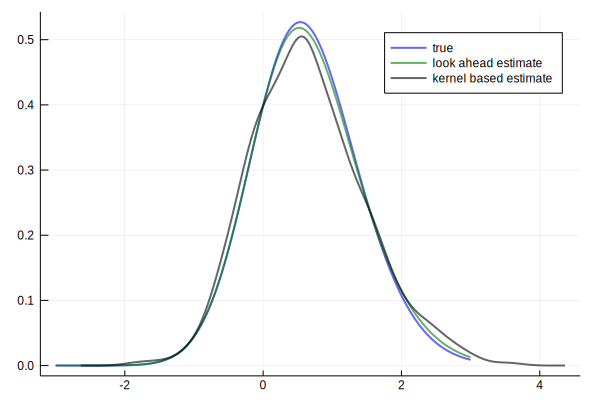

In [6]:
ϕ = Normal()
n = 500
θ = 0.8
d = sqrt(1.0 - θ^2)
δ = θ / d

# true density of TAR model
ψ_star(y) = 2 .* pdf.(ϕ, y) .* cdf.(ϕ, δ * y)

# Stochastic kernel for the TAR model.
p_TAR(x, y) = pdf.(ϕ, (y .- θ .* abs.(x)) ./ d) ./ d

Z = rand(ϕ, n)
X = zeros(n)
for t in 1:n-1
    X[t+1] = θ * abs(X[t]) + d * Z[t]
end

ψ_est(a) = lae_est(LAE(p_TAR, X), a)
k_est = kde(X)

ys = range(-3, 3, length = 200)
plot(ys, ψ_star(ys), color=:blue, lw = 2, alpha = 0.6, label = "true")
plot!(ys, ψ_est(ys), color=:green, lw = 2, alpha = 0.6, label = "look ahead estimate")
plot!(k_est.x, k_est.density, color = :black, lw = 2, alpha = 0.6,
      label = "kernel based estimate")

### Exercise 2

Here’s one program that does the job.

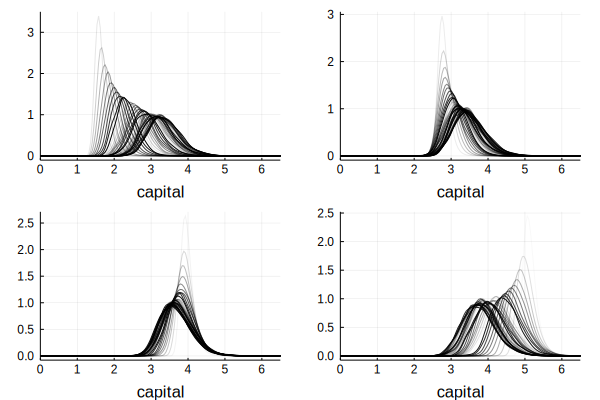

In [7]:
s = 0.2
δ = 0.1
a_σ = 0.4  # A = exp(B) where B ~ N(0, a_σ)
α = 0.4    # We set f(k) = k**α
ψ_0 = Beta(5.0, 5.0)  # Initial distribution
ϕ = LogNormal(0.0, a_σ)

function p_growth(x, y)
    # Stochastic kernel for the growth model with Cobb-Douglas production.
    # Both x and y must be strictly positive.

        d = s * x.^α

    pdf_arg = clamp.((y .- (1-δ) .* x) ./ d, eps(), Inf)
    return pdf.(ϕ, pdf_arg) ./ d
end

n = 1000  # Number of observations at each date t
T = 40    # Compute density of k_t at 1,...,T+1

xmax = 6.5
ygrid = range(0.01, xmax, length = 150)
laes_plot = zeros(length(ygrid), 4T)
colors = []
for i in 1:4
    k = zeros(n, T)
    A = rand!(ϕ, zeros(n, T))

    # Draw first column from initial distribution
    # match scale = 0.5 and loc = 2i in julia version
    k[:, 1] = (rand(ψ_0, n) .+ 2.5i) ./ 2
    for t in 1:T-1
        k[:, t+1] = s * A[:, t] .* k[:, t].^α + (1 - δ) .* k[:, t]
    end

    # Generate T instances of LAE using this data, one for each date t
    laes = [LAE(p_growth, k[:, t]) for t in T:-1:1]
    ind = i
    for j in 1:T
        ψ = laes[j]
        laes_plot[:, ind] = lae_est(ψ, ygrid)
        ind = ind + 4
        push!(colors,  RGBA(0, 0, 0, 1 - (j - 1) / T))
    end
end

#colors = reshape(reshape(colors, T, 4)', 4*T, 1)
colors = reshape(colors, 1, length(colors))
plot(ygrid, laes_plot, layout = (2,2), color = colors,
     legend = :none, xlabel = "capital", xlims = (0, xmax))

### Exercise 3

Here’s a possible solution.

Note the way we use vectorized code to simulate the $ k $ time
series for one boxplot all at once.

In [8]:
n = 20
k = 5000
J = 6

θ = 0.9
d = sqrt(1 - θ^2)
δ = θ / d

initial_conditions = range(8, 0, length = J)

Z = randn(k, n, J)
titles = []
data = []
x_labels = []
for j in 1:J
    title = "time series from t = $(initial_conditions[j])"
    push!(titles, title)

    X = zeros(k, n)
    X[:, 1] .= initial_conditions[j]
    labels = []
    labels = vcat(labels, ones(k, 1))
    for t in 2:n
        X[:, t] = θ .* abs.(X[:, t-1]) .+ d .* Z[:, t, j]
        labels = vcat(labels, t*ones(k, 1))
    end
    X = reshape(X, n*k, 1)
    push!(data, X)
    push!(x_labels, labels)
end

In [9]:
plots = []
for i in 1:J
    push!(plots, boxplot(x_labels[i], data[i], title = titles[i]))
end
plot(plots..., layout = (J, 1), legend = :none, size = (800, 2000))

┌ Warning: seriestype boxplot has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /home/quantecon/.julia/packages/Plots/y6yik/src/args.jl:1054
┌ Warning: seriestype boxplot has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /home/quantecon/.julia/packages/Plots/y6yik/src/args.jl:1054


ErrorException: The backend must not support the series type Val{:boxplot}, and there isn't a series recipe defined.

## Appendix


<a id='statd-appendix'></a>
Here’s the proof of [(6)](#equation-statd-dv)

Let $ F_U $ and $ F_V $ be the cumulative distributions of $ U $ and $ V $ respectively

By the definition of $ V $, we have $ F_V(v) = \mathbb P \{ a + b U \leq v \} = \mathbb P \{ U \leq (v - a) / b \} $

In other words, $ F_V(v) = F_U ( (v - a)/b ) $

Differentiating with respect to $ v $ yields [(6)](#equation-statd-dv)